# Predict the closing price, Model: SARIMAX, Stock Token: ITD, Train/Test/Validation/: 80/10/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 168.4
- MAE: 144.24
- MAPE: 1.24 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> ITD - 8 1 1
split = 2
stock = 2  # ITD

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1247,2024-02-26,9520,9700,9510,9700,8700,ITD
1248,2024-02-27,9690,9690,9210,9640,17500,ITD
1249,2024-02-28,9450,10000,9400,9890,35700,ITD
1250,2024-02-29,9890,9960,9430,9950,53400,ITD


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [39]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [40]:
# Shape of the dataframe
df.shape

(1252, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,9957.242013,10146.194089
std,2982.882283,3069.392776
min,5130.000000,5320.000000
25%,7430.000000,7515.000000
50%,9825.000000,10000.000000
75%,11550.000000,11700.000000
max,20700.000000,21430.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

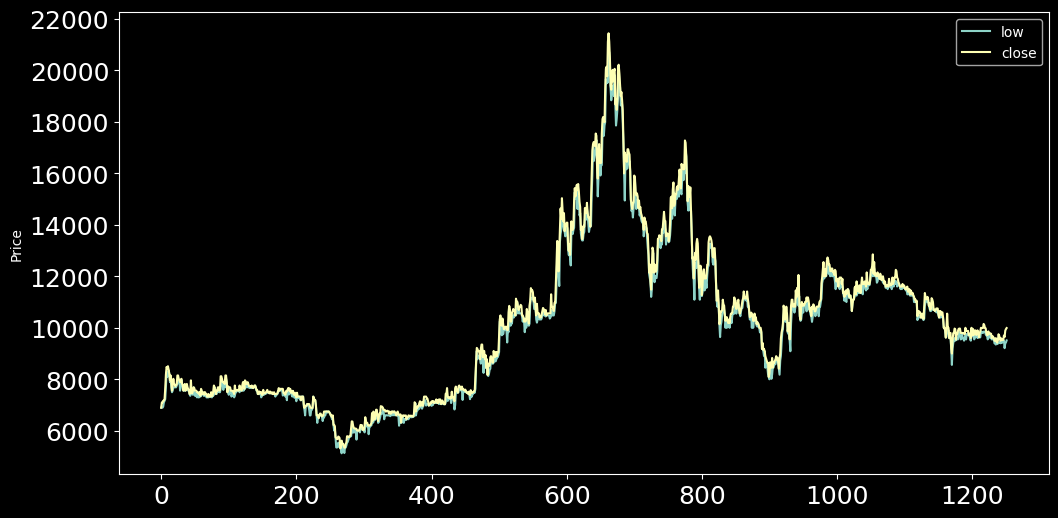

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.6093516999032065,
 0.4788943246246586,
 12,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 17400.706231746055)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.692
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.718
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


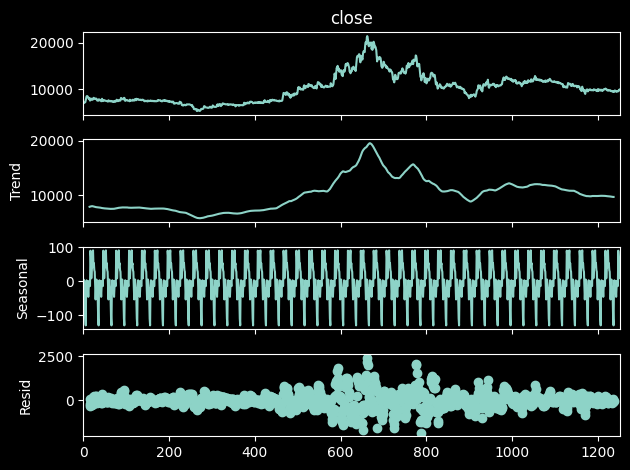

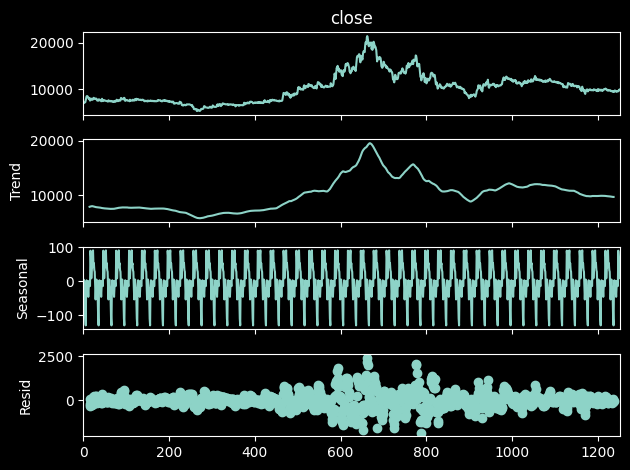

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-9.524329056695077,
 3.0060214366681975e-16,
 11,
 988,
 {'1%': -3.4369860032923145,
  '5%': -2.8644697838498376,
  '10%': -2.5683299626694422},
 13964.543207932225)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

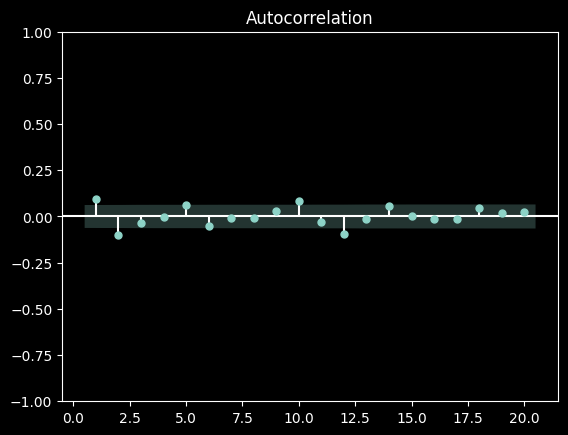

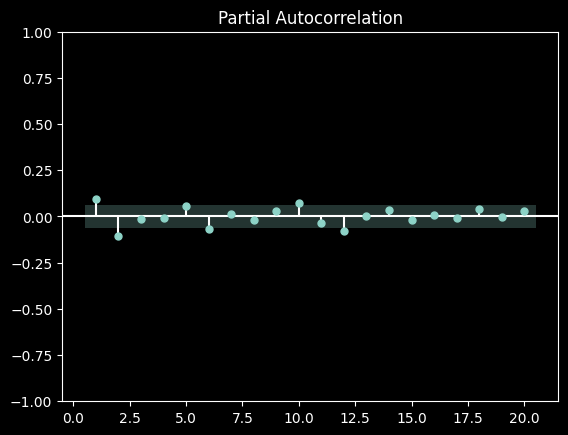

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=14284.244, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14302.266, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14292.664, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14290.941, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14300.530, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=14287.048, Time=0.29 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=14286.295, Time=0.39 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=14282.479, Time=0.94 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=14281.739, Time=1.01 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=14280.623, Time=0.72 sec
 ARIMA(1,1,2)(1,0,0)[5] intercept   : AIC=14284.481, Time=0.13 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : AIC=14280.696, Time=0.65 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=14282.910, Time=0.41 sec
 ARIMA(0,1,2)(2,0,0)[5] intercept   : AIC=14279.849, Time=0.11 sec
 ARIMA(0,1,2)(1,0,0

In [56]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1001
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 5)   Log Likelihood               -7134.023
Date:                            Sun, 26 May 2024   AIC                          14278.045
Time:                                    13:42:39   BIC                          14302.584
Sample:                                         0   HQIC                         14287.372
                                           - 1001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1074      0.022      4.950      0.000       0.065       0.150
ma.L2         -0.0886      0.022   

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(2, 0, 0, 5),
)

model_fit = model1.fit()

### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([11996.82738328, 11826.07362558, 11858.64389435, 11682.85489889,
       11994.55267872, 11852.31570428, 11828.47402898, 11846.05162639,
       11547.77234463, 11454.48419472, 11260.58299458, 11464.82251887,
       11267.89113613, 11209.36576937, 11661.31432075, 11712.39868834,
       11664.20263197, 11365.05049304, 11461.66600261, 11462.17624578,
       11262.32296252, 10862.0761933 , 11162.86320929, 11312.30704316,
       11312.42248564, 11412.67935498, 11512.98218904, 11513.08653766,
       11462.73094791, 11562.92962498, 11562.9653191 , 11563.00029572,
       11563.02736587, 11562.95735714, 11562.96750795, 11713.21451174,
       11913.5435991 , 11512.91675459, 11913.52984175, 11913.53304857,
       11913.53589431, 11713.22127739, 11663.1441725 , 11813.37641011,
       11713.21845785, 11913.53685469, 11913.53778462, 11863.4590662 ,
       12013.69548282, 12264.09279572, 12464.41066781, 12414.33151414,
       12214.01406773, 12314.1723821 , 12514.49009585, 12214.01369914,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([10594.60389963, 10574.08837232, 10556.57923097, 10531.0284659 ,
       11043.04388625, 11201.28337259, 11277.60051755, 11295.17811496,
       11197.21647372, 11204.08714407, 11060.26535406, 10964.02841757,
       10867.25585509, 10858.80989845, 10960.20257893, 11011.28694652,
       10913.01148002, 10914.33580187, 10910.79249118, 10861.22332422,
       10861.68768148, 10811.99678317, 10862.38674851, 10811.51294186,
       10711.46956408, 10611.40879289, 10611.5528067 , 10611.65715532,
       10661.46038583, 10661.50024264, 10611.45652663, 10561.41209311,
       10210.88329236, 10210.81328362, 10110.66461418,  9830.22869085,
        9860.28778376, 10210.85209121, 10030.54402086, 10120.69016592,
        9810.20066884,  9810.20369245,  9810.20599769,  9409.56472387,
        8768.5491422 ,  9409.56634819,  9609.88491864,  9720.06031264,
        9810.2014371 ,  9710.04287909,  9740.09075673,  9750.10689522,
        9810.20238148,  9760.12246546, 10060.59899948, 10010.51965342,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[15363.40129317 15400.13326833 15439.87162945 15371.4095466
 15389.798958   15404.9683063  15438.37413347 15463.11982323
 15422.40568447 15436.44444717 15450.02897989 15461.11895601
 15471.67330614 15470.39544185 15478.79739441 15486.97044422
 15496.02189033 15504.51430453 15508.13908618 15515.8174217
 15523.44987131 15531.00647548 15538.48512304 15544.85881886
 15552.14235369 15559.40849511 15566.72060126 15573.99304223
 15580.88495495 15588.09290411]


### Plotting the data


In [63]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

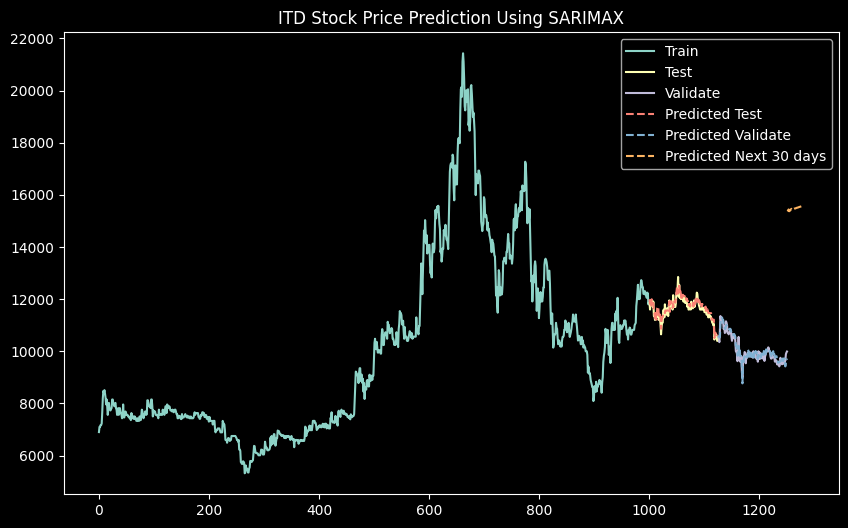

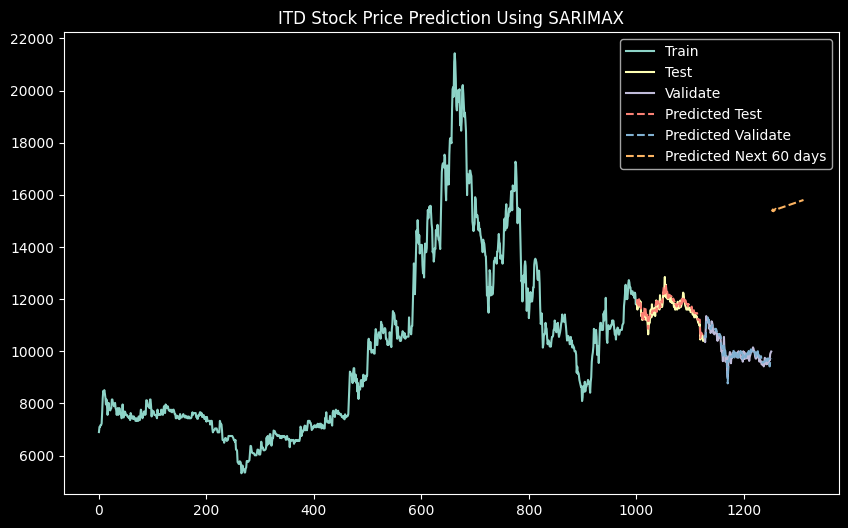

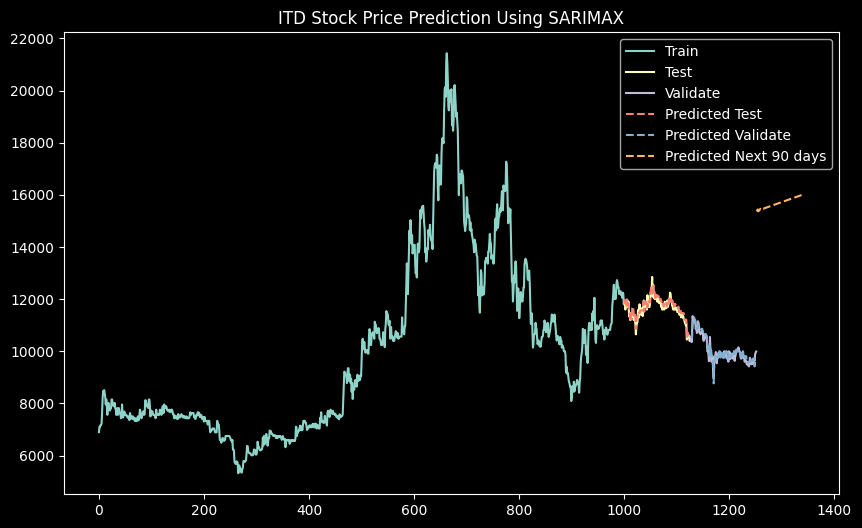

In [64]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 168.40433150475803
MAE on test data: 144.24121951457968
MAPE on test data: 1.2425520836509991 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 144.81891290343125
MAE on validation data: 121.98970098078074
MAPE on validation data: 1.2186645945402195 %
